# Stacking

Ensemble learning helps improve machine learning results by combining several base models. This approach often leads to better predictive performance compared to a single base model alone. Ensemble learning has been proved to be very effective and used extensively in many machine learning competitions, such as the Netflix prize competition and Kaggle.

Like bagging (Random Forest) and boosting (Gradient Boosted Trees) covered in the last lab, stacked generalization (stacking) is another ensemble learning method, which introduces a different way of combining multiple base models to achieve better model prediction. The idea behind stacking is fairly simple: instead of using trivial functions (such as hard voting) to aggregate the predictions of the base learners, we train a model to perform this aggregation, called meta learner or blender. This idea is captured in the following diagram.

<img src="stacking.png" alt="drawing" width="800"/>

In this lab assignment, you will implement the stacking method and apply it on several machine learning benchmark datasets.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

In [2]:
# helper functions used in this lab
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    """
    Plot the decision boundary of a learnt classifier
    """
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
def evaluate_model(model, X, y):
    # make prediction and evaluate the model performance on test data
    z_prob = model.predict_proba(X)[:,1]

    print("model ROC AUC: {}".format(roc_auc_score(y, z_prob)))

### Synthetic Moon Dataset
In this lab, we will classify a moon shaped synthetic dataset with two features (_x1_ and _x2_) and two classes (0 or 1) with some added noise. We use this synthetic dataset because it's easier to help demonstrate the pros and cons of different SVM models covered in this lab.

In [3]:
# load the moon train and test data from CSV files
train = pd.read_csv("moon_train.csv")
test = pd.read_csv("moon_test.csv")

train_x = train.iloc[:,0:2]
train_y = train.iloc[:,2]

test_x = test.iloc[:,0:2]
test_y = test.iloc[:,2]

print("Number of train data: {}".format(len(train_y)))
print("Number of test data: {}".format(len(test_y)))

Number of train data: 3000
Number of test data: 1000


Text(0,0.5,'x2')

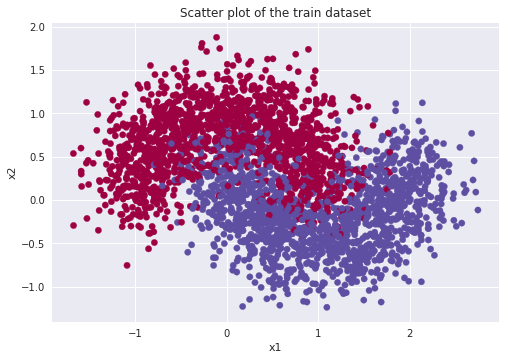

In [4]:
# plot the train dataset
plt.scatter(train_x.x1, train_x.x2, s=40, c=train_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the train dataset')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0,0.5,'x2')

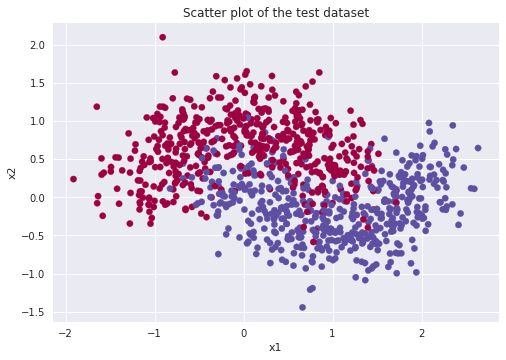

In [5]:
# plot the test dataset
plt.scatter(test_x.x1, test_x.x2, s=40, c=test_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the test dataset')
plt.xlabel('x1')
plt.ylabel('x2')

## Stacking Implementation

<span style="color:orange">**Coding Part 1: train three base learners separately and evaluate their performance on the test set. We later compare our own implementation of stacking against the performance of these base learners in terms of AUC.**</span> 

### K nearest neighbors
- Train a K nearest neighbors model
- Plot the decision boundary
- Evaluate the model performance on the test set.

In [6]:
# TODO: train a KNN model
parameters = {
    "n_neighbors": [2, 4, 8]
}
knn_model = GridSearchCV(KNeighborsClassifier(), parameters, cv=3)
knn_model.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 4, 8]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

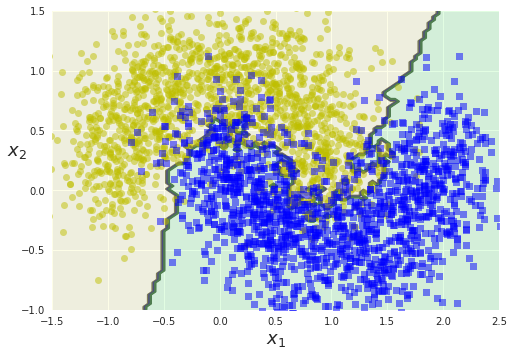

In [7]:
# plot the decision boundary
plot_decision_boundary(knn_model, train_x.values, train_y.values)

In [8]:
# make prediction and evaluate the model performance on test data
evaluate_model(knn_model, test_x, test_y)

model ROC AUC: 0.9470320000000001


###  Linear SVM
- Train a linear SVM model
- Plot the decision boundary
- Evaluate the model performance on the test set.

In [9]:
# train the model
parameters = {
    "C": [0.01, 0.1, 1, 10, 100]
}
linear_svc_model = GridSearchCV(SVC(kernel="linear", probability=True, random_state=0), parameters, cv=3)
linear_svc_model.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

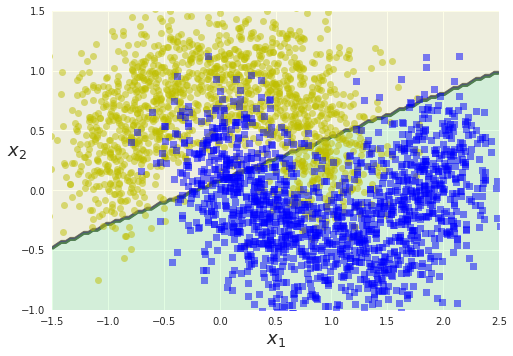

In [10]:
# plot the decision boundary
plot_decision_boundary(linear_svc_model, train_x.values, train_y.values)

In [11]:
# make prediction and evaluate the model performance on test data
evaluate_model(linear_svc_model, test_x, test_y)

model ROC AUC: 0.925706


### Decision Tree
- Train a decision tree
- Plot the decision boundary
- Evaluate the model performance on the test set.

In [12]:
# train the model
parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [1, 2, 4, 8], 
    'min_samples_split': [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
}

dt_model = GridSearchCV(DecisionTreeClassifier(random_state=0), parameters, cv=3)
dt_model.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [0.01, 0.05, 0.1, 0.2, 0.4, 0.8], 'max_depth': [1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

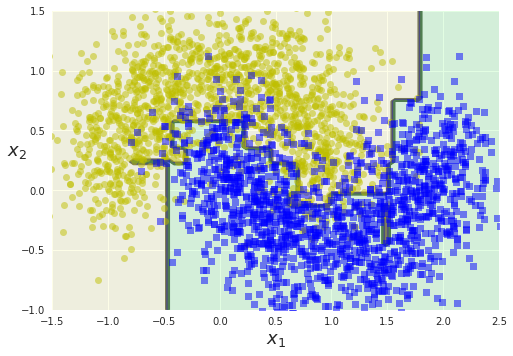

In [13]:
# plot the decision boundary
plot_decision_boundary(dt_model, train_x.values, train_y.values)

In [14]:
# make prediction and evaluate the model performance on test data
evaluate_model(dt_model, test_x, test_y)

model ROC AUC: 0.953582


## Stacking Implementation

<span style="color:orange">**Coding Part 2: implement the stacking algorithm for a binary classification task.**</span> 

### Two-layer Stacking model

Given a two-layer stacking architecture with $N$ base learners in the first cell of this notebook, the algorithm works as follows: 
- Step 1: the training set is split into two subsets: _Fold 1_ and _Fold 2_.
- Step 2: the first subset _Fold 1_ is used to train the $N$ base models in the first layer.
- Step 3: the first layer base learners are used to make predictions on the second set.
- Step 4: for each instance in the second set _Fold 2_, there are $N$ predicted values, one from each base learner. Now, we create a new training set using these predicted values as input features together with the original label as target. 
- Step 5: train the meta learner (or blender) on this new training dataset so it learns to predict the target value based on the predictions from the base learner in the first layer.

Now, given a new instance in the test set, we first use the base learners in the first layer to make predictions, and then use these predictions to feed to the meta learner to get the final prediction. 


### Multiple-layer Stacking
We can actually extend the idea of stacking to more than 2 layers. For example in a 3-layer stacking framework, we can split the training dataset into 3-fold where the first fold is used to train the base learners in the first layers, the second fold is used to train the learners in the middle layer, and the last fold is used to train the final blender. Same as the 2-layer stacking, learners in the middle and last layer use the predictions from learners from the previous layer. Once training is done, we can make a prediction for a new instance by going through each layer sequentially as before.

In this exercise, you will implement a two-layer stacking algorithm with the following components:
- Three base learners in the first layer, including Logistic Regression, Support Vector Machine, and Decision Tree. 
- A logistic regression model as the meta learner or blender.

In [15]:
class MyStacking:
    """
    Stacking
    """
    def __init__(self):
        self.model_knn = None
        self.model_svc = None
        self.model_dt = None
        self.blender = None

    def train(self, x, y):
        """
        TODO: train the stacking model with {KNN, SVM, decision tree} as the base learners 
              and a logistic regression model as the blender
        """
        #--------------------------------------------
        # TODO: random split the training set x into two folds
        #--------------------------------------------
        idx = np.random.choice(x.index, size=len(x)//2, replace=False)
        x_fold1 = x.loc[x.index.isin(idx)]
        x_fold2 = x.loc[~x.index.isin(idx)]
        y_fold1 = y.loc[y.index.isin(idx)]
        y_fold2 = y.loc[~y.index.isin(idx)]
        
        #--------------------------------------------
        # TODO: learn the base learners using data in fold 1
        #--------------------------------------------
        # learn the KNN base learner
        print("learn the K nearest neighbor base learner...")
        parameters = {
            "n_neighbors": [2, 4, 8]
        }
        self.model_knn = GridSearchCV(KNeighborsClassifier(), parameters, cv=3)
        self.model_knn.fit(x_fold1, y_fold1)

        # learn the SVM base learner
        print("learn the support vector machine base learner...")
        parameters = {
            "C": [0.01, 0.1, 1, 10, 100]
        }
        self.model_svc = GridSearchCV(SVC(kernel="linear", probability=True, random_state=0), parameters, cv=3)
        self.model_svc.fit(x_fold1, y_fold1)

        # learn the decision tree base learner
        print("learn the decision tree base learner...")
        parameters = {
            'criterion': ['gini', 'entropy'], 
            'max_depth': [1, 2, 4, 8], 
            'min_samples_split': [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
        }
        self.model_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), parameters, cv=3)
        self.model_dt.fit(x_fold1, y_fold1)

        #--------------------------------------------
        # TODO: learn the blender using predictions on fold2 from the base learners as features
        #--------------------------------------------
        # make predictions using the base learns to generate the training data for the blender
        x = pd.DataFrame(
            data = {
                'x_1': self.model_knn.predict_proba(x_fold2)[:,0],
                'x_2': self.model_svc.predict_proba(x_fold2)[:,0],
                'x_3': self.model_dt.predict_proba(x_fold2)[:,0]
            }
        )
        y = y_fold2
                
        print("learn the blender...")
        parameters = {
            "penalty": ["l1", "l2"], 
            "C": [0.001, 0.01, 0.1, 1, 10]
        }
        self.blender = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=3)
        self.blender.fit(x, y)

    def predict_proba(self, x):
        """
        TODO: Make predictions (probabilities) with the trained stacking model.
        """
        if self.blender == None:
            sys.exit("The model has not been trained yet. Please call train() first. Exiting...")

        # predictions from the base learner 
        base_model_predictions = pd.DataFrame(
            data = {
                'x_1': self.model_knn.predict_proba(x)[:,0],
                'x_2': self.model_svc.predict_proba(x)[:,0],
                'x_3': self.model_dt.predict_proba(x)[:,0]
            }
        )
        
        # predictions from the blender
        probabilities = self.blender.predict_proba(base_model_predictions)
        return probabilities

    def predict(self, x):
        """
        TODO: Make predictions (the class/label) with the trained stacking model.
        """
        probabilities = self.predict_proba(x)[:,1]
        prediction = pd.Series([1] * len(probabilities))
        prediction[probabilities < 0.5] = 0

        return prediction.values

In [16]:
# train random forest classifier
my_stacking = MyStacking()
my_stacking.train(train_x, train_y)

learn the K nearest neighbor base learner...
learn the support vector machine base learner...
learn the decision tree base learner...
learn the blender...


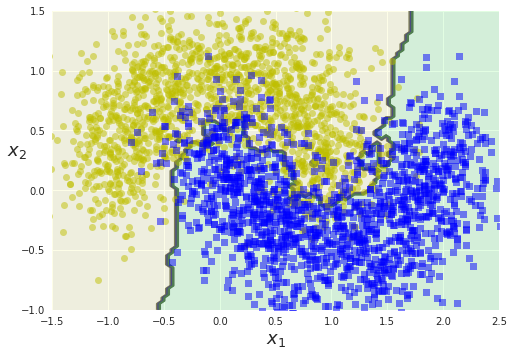

In [17]:
# plot the decision boundary
plot_decision_boundary(my_stacking, train_x.values, train_y.values)

In [18]:
# make prediction and evaluate the model performance on test data
evaluate_model(my_stacking, test_x, test_y)

model ROC AUC: 0.95583


### Comparison
Your stacking model should outperform each individual learner by a small margin in terms of AUC. 

### End of ML 310 Lab Assignment 5
---